In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
TRAIN_PATH = '/kaggle/input/chaii-hindi-and-tamil-question-answering/train.csv'

### Reading Training Data

In [6]:
train_df = pd.read_csv(TRAIN_PATH)

train_df.head()

,id,context,question,answer_text,answer_start,language
0,903deec17,ஒரு சாதாரண வளர்ந்த மனிதனுடைய எலும்புக்கூடு பின...,மனித உடலில் எத்தனை எலும்புகள் உள்ளன?,206,53,tamil
1,d9841668c,காளிதாசன் (தேவநாகரி: कालिदास) சமஸ்கிருத இலக்கி...,காளிதாசன் எங்கு பிறந்தார்?,காசுமீரில்,2358,tamil
2,29d154b56,சர் அலெக்ஸாண்டர் ஃபிளெமிங் (Sir Alexander Flem...,பென்சிலின் கண்டுபிடித்தவர் யார்?,சர் அலெக்ஸாண்டர் ஃபிளெமிங்,0,tamil
3,41660850a,"குழந்தையின் அழுகையை நிறுத்தவும், தூங்க வைக்கவ...",தமிழ்நாட்டில் குழந்தைகளை தூங்க வைக்க பாடும் பா...,தாலாட்டு,68,tamil
4,b29c82c22,சூரியக் குடும்பம் \nசூரியக் குடும்பம் (Solar S...,பூமியின் அருகில் உள்ள விண்மீன் எது?,சூரியனும்,585,tamil


In [7]:
train_df.isnull().sum(axis=0)

id              0
context         0
question        0
answer_text     0
answer_start    0
language        0
dtype: int64

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1114 entries, 0 to 1113
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1114 non-null   object
 1   context       1114 non-null   object
 2   question      1114 non-null   object
 3   answer_text   1114 non-null   object
 4   answer_start  1114 non-null   int64 
 5   language      1114 non-null   object
dtypes: int64(1), object(5)
memory usage: 52.3+ KB


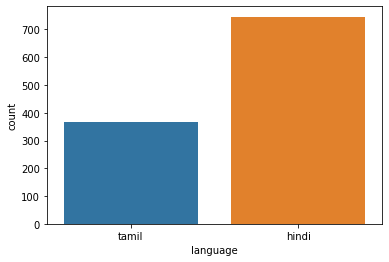

In [6]:
_ = sns.countplot(train_df['language'])

In [9]:
context = train_df.query("language == 'hindi'").iloc[0,1] # 2nd Column
question = train_df.query("language == 'hindi'").iloc[0,2] # 3rd column
answer = train_df.query("language == 'hindi'").iloc[0,3] # 4th Column
answer_start = train_df.query("language == 'hindi'").iloc[0,4] # 5th Column

print(f"{question} --> {answer}, start : {answer_start}")

सन १८८६ में किसने बताया कि तम्बाकू में मोजेक रोग एक विशेष प्रकार के वाइरस के द्वारा होता है? --> एडोल्फ मेयर, start : 935


In [10]:
context[answer_start:answer_start + len(answer)]

'एडोल्फ मेयर'

### Max context length 

In [11]:
max([len(x) for x in train_df['context'].values])

49815

### Preprocessing the Training Data

In [12]:
import transformers
from transformers import AutoTokenizer

model_checkpoint = "/kaggle/input/xlm-roberta-squad2/deepset/xlm-roberta-large-squad2"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

2021-09-23 15:56:49.352574: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [13]:
tokenizer('What is your name?','Ashraf')

{'input_ids': [0, 4865, 83, 935, 9351, 32, 2, 2, 209711, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

One specific thing for the preprocessing in question answering is how to deal with very long documents. We usually truncate them in other tasks, when they are longer than the model maximum sentence length, but here, removing part of the the context might result in losing the answer we are looking for. To deal with this, we will allow one (long) example in our dataset to give several input features, each of length shorter than the maximum length of the model (or the one we set as a hyper-parameter). Also, just in case the answer lies at the point we split a long context, we allow some overlap between the features we generate controlled by the hyper-parameter doc_stride:

In [14]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

In [15]:
question = train_df.iloc[0]['question']
context = train_df.iloc[0]['context']

len(tokenizer(question, context)['input_ids'])

Token indices sequence length is longer than the specified maximum sequence length for this model (1504 > 512). Running this sequence through the model will result in indexing errors


1504

In [14]:
len(tokenizer(question, context, max_length=max_length, truncation="only_second")["input_ids"])

384

Note that we never want to truncate the question, only the context, else the only_second truncation picked. Now, our tokenizer can automatically return us a list of features capped by a certain maximum length, with the overlap we talked above, we just have to tell it with return_overflowing_tokens=True and by passing the stride:

In [15]:
tokenized_example = tokenizer(
    question,
    context,
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

Now we don't have one list of input_ids, but several:

In [16]:
[len(x) for x in tokenized_example['input_ids']]

[384, 384, 384, 384, 384, 294]

See the overlap Below

In [16]:
question = "What is the music?"
context = """Music is the art of arranging sounds in time to produce a composition through the elements of melody, harmony, rhythm, and timbre.[1][2]It is one of the universal cultural aspects of all human societies. General definitions of music include common elements such as pitch (which governs melody and harmony), rhythm (and its associated concepts tempo, meter, and articulation), dynamics (loudness and softness), and the sonic qualities of timbre and texture (which are sometimes termed the "color" of a musical sound)."""
answer = "art of arranging sounds"
answer_start = 13

tokenized_example = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=30
)

print([len(x) for x in tokenized_example["input_ids"]])

for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[100, 69]
<s> What is the music?</s></s> Music is the art of arranging sounds in time to produce a composition through the elements of melody, harmony, rhythm, and timbre.[1][2]It is one of the universal cultural aspects of all human societies. General definitions of music include common elements such as pitch (which governs melody and harmony), rhythm (and its associated concepts tempo, meter, and articulation), dynamics (loudness</s>
<s> What is the music?</s></s>s melody and harmony), rhythm (and its associated concepts tempo, meter, and articulation), dynamics (loudness and softness), and the sonic qualities of timbre and texture (which are sometimes termed the "color" of a musical sound).</s>


#### Offset Mapping


Now this will give us some work to properly treat the answers: we need to find in which of those features the answer actually is, and where exactly in that feature. The models we will use require the start and end positions of these answers in the tokens, so we will also need to to map parts of the original context to some tokens. Thankfully, the tokenizer we're using can help us with that by returning an offset_mapping:

In [18]:
tokenized_example = tokenizer(
    question,
    context,
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)

tokenized_example["offset_mapping"][0][:20]

[(0, 0),
 (0, 4),
 (4, 7),
 (7, 11),
 (11, 17),
 (17, 18),
 (0, 0),
 (0, 0),
 (0, 5),
 (5, 8),
 (8, 12),
 (12, 16),
 (16, 19),
 (19, 25),
 (25, 29),
 (29, 36),
 (36, 39),
 (39, 44),
 (44, 47),
 (47, 55)]

This gives, for each index of our input IDS, the corresponding start and end character in the original text that gave our token. The very first token ([CLS]) has (0, 0) because it doesn't correspond to any part of the question/answer

In [19]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]

print(tokenizer.convert_ids_to_tokens([first_token_id])[0], question[offsets[0]:offsets[1]])

▁What What


In [18]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, None, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None]


It returns None for the special tokens, then 0 or 1 depending on whether the corresponding token comes from the first sentence past (the question) or the second (the context). Now with all of this, we can find the first and last token of the answer in one of our input feature (or if the answer is not in this feature):

In [19]:
start_char = answer_start
end_char = start_char + len(answer)


# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1
    
print("Passage Start:", token_start_index)
print("Passage End:", token_end_index)
    
offsets = tokenized_example["offset_mapping"][0]

if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

Passage Start: 8
Passage End: 98


KeyError: 'offset_mapping'

Verifying Fetched Answer with Answer in the Dataset

In [22]:
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
print(answer)

art of arranging sounds
art of arranging sounds


In [20]:
pad_on_right = tokenizer.padding_side == "right"

Now let's put everything together in one function we will apply to our training set. In the case of impossible answers (the answer is in another feature given by an example with a long context), we set the cls index for both the start and end position. We could also simply discard those examples from the training set if the flag allow_impossible_answers is False.

### Preparing Dataset For Bert Model

In [21]:
def convert_answers(r):
    start = r[0]
    text = r[1]
    return {
        'answer_start': [start],
        'text': [text]
    }

train_df = train_df.sample(frac=1, random_state=42)
train_df['answers'] = train_df[['answer_start', 'answer_text']].apply(convert_answers, axis=1)

train_df["answers"][0]

{'answer_start': [53], 'text': ['206']}

In [22]:
df_train = train_df[:-64].reset_index(drop=True)
df_valid = train_df[-64:].reset_index(drop=True)

In [23]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(df_train)
valid_dataset = Dataset.from_pandas(df_valid)

In [11]:
train_dataset[4]

{'id': '4f99ce2e0',
 'context': 'எம். ஜி. ஆர் என்ற பெயரில் புகழ் பெற்ற, மருதூர் கோபாலமேனன் இராமச்சந்திரன் (எம். ஜி. இராமச்சந்திரன், சனவரி 17, 1917 – திசம்பர் 24, 1987), தமிழ்த் திரைப்பட நடிகராகவும் 1977 முதல் இறக்கும் வரை தமிழ்நாட்டின் தொடர்ந்து மூன்று முறை முதலமைச்சராகவும் இருந்தவர்.\nஎம். ஜி. சக்கரபாணிக்குத் தம்பியான இவர்,[1] தொடக்க காலத்தில் நாடகங்களில் நடித்தார். காந்தியடிகளின் கருத்துகளால் ஈர்க்கப்பெற்று  இந்திய தேசிய காங்கிரசில் இணைந்தார்.[2] சதிலீலாவதி என்ற திரைப்படம் மூலம் தமிழக திரைத்துறையில் அறிமுகமாகி, கதாநாயகனாக மாறிய பிறகு, அறிஞர் அண்ணாவின் அரசியல் கருத்துகளில் ஈர்க்கப்பெற்று திராவிட முன்னேற்றக் கழகத்தில் இணைந்தார். அண்ணாவின் மறைவுக்குப்பிறகு, கருணாநிதியால் திமுகவிலிருந்து நீக்கப்பட்டார். அதன் பின் அண்ணா திராவிட முன்னேற்றக் கழகம் என்ற அரசியல் கட்சியைத் தொடங்கி, தேர்தலில் நின்று தொடர்ந்து மூன்று முறை தமிழகத்தில் வெற்றிபெற்று முதலமைச்சரானார்.\nஇவர் உயரிய விருதுகளில் ஒன்றான பாரத ரத்னா விருதினை பெற்றவர்.[3]\n தனிப்பட்ட வாழ்க்கை \n இளமைப்பருவம் \nஇராமச்சந்திரன் இலங்கையின் கண்டி

In [24]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [25]:
tokenized_train_ds = train_dataset.map(prepare_train_features, batched=True, remove_columns=train_dataset.column_names)
tokenized_valid_ds = valid_dataset.map(prepare_train_features, batched=True, remove_columns=train_dataset.column_names)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [26]:
tokenized_train_ds

Dataset({
    features: ['attention_mask', 'end_positions', 'input_ids', 'start_positions'],
    num_rows: 13925
})

### Fine-tuning the model

Now that our data is ready for training, we can download the pretrained model and fine-tune it. Since our task is question answering, we use the AutoModelForQuestionAnswering class. Like with the tokenizer, the from_pretrained method will download and cache the model for us:

In [27]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

In [28]:
%env WANDB_DISABLED=True

env: WANDB_DISABLED=True


To instantiate a Trainer, we will need to define three more things. The most important is the TrainingArguments, which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [29]:
batch_size = 4

args = TrainingArguments(
    f"chaii-qa",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=3e-5,
    warmup_ratio=0.1,
    gradient_accumulation_steps=8,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=1,
    weight_decay=0.01,
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


we will need a data collator that will batch our processed examples together, here the default one will work:

In [30]:
from transformers import default_data_collator

data_collator = default_data_collator

In [31]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_valid_ds,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [36]:
trainer.train()

***** Running training *****
  Num examples = 13925
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 8
  Total optimization steps = 435


Epoch,Training Loss,Validation Loss
0,No log,0.264647


***** Running Evaluation *****
  Num examples = 816
  Batch size = 4
Saving model checkpoint to chaii-qa/checkpoint-435
Configuration saved in chaii-qa/checkpoint-435/config.json
Model weights saved in chaii-qa/checkpoint-435/pytorch_model.bin
tokenizer config file saved in chaii-qa/checkpoint-435/tokenizer_config.json
Special tokens file saved in chaii-qa/checkpoint-435/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=435, training_loss=0.26519854315396013, metrics={'train_runtime': 1966.3219, 'train_samples_per_second': 7.082, 'train_steps_per_second': 0.221, 'total_flos': 9695700997816320.0, 'train_loss': 0.26519854315396013, 'epoch': 1.0})

In [32]:
trainer.save_model("test-chaii-trained")

Saving model checkpoint to test-chaii-trained
Configuration saved in test-chaii-trained/config.json
Model weights saved in test-chaii-trained/pytorch_model.bin
tokenizer config file saved in test-chaii-trained/tokenizer_config.json
Special tokens file saved in test-chaii-trained/special_tokens_map.json


### Evaluation


Evaluating our model will require a bit more work, as we will need to map the predictions of our model back to parts of the context. The model itself predicts logits for the start and en position of our answers: if we take a batch from our validation datalaoder, here is the output our model gives us:

In [33]:
import torch

for batch in trainer.get_eval_dataloader():
    break
    
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

In [34]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([4, 384]), torch.Size([4, 384]))

We have one logit for each feature and each token. The most obvious thing to predict an answer for each featyre is to take the index for the maximum of the start logits as a start position and the index of the maximum of the end logits as an end position.

In [35]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

(tensor([0, 0, 0, 0], device='cuda:0'), tensor([0, 0, 0, 0], device='cuda:0'))

This will work great in a lot of cases, but what if this prediction gives us something impossible: the start position could be greater than the end position, or point to a span of text in the question instead of the answer. In that case, we might want to look at the second best prediction to see if it gives a possible answer and select that instead.

However, picking the second best answer is not as easy as picking the best one: is it the second best index in the start logits with the best index in the end logits? Or the best index in the start logits with the second best index in the end logits? And if that second best answer is not possible either, it gets even trickier for the third best answer.

To classify our answers, we will use the score obtained by adding the start and end logits. We won't try to order all the possible answers and limit ourselves to with a hyper-parameter we call n_best_size. We'll pick the best indices in the start and end logits and gather all the answers this predicts. After checking if each one is valid, we will sort them by their score and keep the best one. Here is how we would do this on the first feature in the batch:

In [36]:
n_best_size = 20

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

And then we can sort the valid_answers according to their score and only keep the best one. The only point left is how to check a given span is inside the context (and not the question) and how to get back the text inside. To do this, we need to add two things to our validation features:

the ID of the example that generated the feature (since each example can generate several features, as seen before);
the offset mapping that will give us a map from token indices to character positions in the context.
That's why we will re-process the validation set with the following function, slightly different from prepare_train_features:

In [37]:
def prepare_validation_features(examples):

    examples["question"] = [q.lstrip() for q in examples["question"]]

    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )


    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [38]:
validation_features = valid_dataset.map(
    prepare_validation_features,
    batched=True,
    remove_columns=valid_dataset.column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [39]:
print(len(validation_features))

validation_features

816


Dataset({
    features: ['attention_mask', 'example_id', 'input_ids', 'offset_mapping'],
    num_rows: 816
})

In [40]:
max_answer_length = 30

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = valid_dataset[0]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 0.41045284, 'text': 'प्रतिभा पाटील'},
 {'score': 0.3517133, 'text': 'कुशल सिंह'},
 {'score': -0.3804469,
  'text': 'प्रतिभा पाटील (पहली महिला राज्यपाल और फिर भारत की पहली महिला राष्ट्रपति)\n- *वसुंधरा राजे'},
 {'score': -0.84025526, 'text': 'वसुंधरा राजे'},
 {'score': -1.7338163,
  'text': 'कुशल सिंह (पहली महिला मुख्य सचिव) \n- *कांता खतूरिया'},
 {'score': -1.767897,
  'text': 'प्रतिभा पाटील (पहली महिला राज्यपाल और फिर भारत की पहली महिला राष्ट्रपति'},
 {'score': -1.9341971, 'text': 'प्रतिभा पाटील (पहली महिला राज्यपाल'},
 {'score': -2.1618233,
  'text': 'प्रतिभा पाटील (पहली महिला राज्यपाल और फिर भारत की पहली महिला राष्ट्रपति)\n- *वसुंधरा राजे (पहली महिला मुख्यमंत्री'},
 {'score': -2.5742593, 'text': ' *प्रतिभा पाटील'},
 {'score': -2.6216316, 'text': 'वसुंधरा राजे (पहली महिला मुख्यमंत्री'},
 {'score': -2.9836292, 'text': 'प्रतिभा पाटील (पहली महिला'},
 {'score': -3.2432017,
  'text': 'प्रतिभा पाटील (पहली महिला राज्यपाल और फिर भारत की पहली महिला'},
 {'score': -3.365159,
  'text'

In [41]:
valid_dataset[0]["answers"]['text']

['प्रतिभा पाटील']

In [42]:
validation_features = validation_features.map(lambda example: example, remove_columns=['example_id', 'offset_mapping'])
validation_features

  0%|          | 0/816 [00:00<?, ?ex/s]

Dataset({
    features: ['attention_mask', 'input_ids'],
    num_rows: 816
})

In [43]:
raw_predictions = trainer.predict(validation_features)

***** Running Prediction *****
  Num examples = 816
  Batch size = 4


We're almost ready for our post-processing function. The last bit to deal with is the impossible answer (when squad_v2 = True). The code above only keeps answers that are inside the context, we need to also grab the score for the impossible answer (which has start and end indices corresponding to the index of the CLS token). When one example gives several features, we have to predict the impossible answer when all the features give a high score to the impossible answer (since one feature could predict the impossible answer just because the answer isn't in the part of the context it has access too), which is why the score of the impossible answer for one example is the minimum of the scores for the impossible answer in each feature generated by the example.

We then predict the impossible answer when that score is greater than the score of the best non-impossible answer. All combined together, this gives us this post-processing function:

In [37]:
import collections

examples = valid_dataset
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

KeyError: 'example_id'